<a href="https://colab.research.google.com/github/tkornuta-semiotic/2023-05-AI-workshop/blob/main/notebooks/Image_Recognition_with_HuggingFace_and_ResNet_FineTuning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Image Recognition with PyTorch and ResNet-18

Description: In this tutorial, you will learn how to train an image recognition model using HuggingFace's datasets and models, and monitor training vs validation accuracy to detect overfitting. You will also learn how to fine-tune a pretrained ResNet encoder to achieve faster convergence.

In [1]:
!pip install torch datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.3 MB/s eta 0:00:00


In [2]:
# Step 1: Prerequisites.
# 1.1 Import necessary libraries
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import models, transforms
from torchsummary import summary

from datasets import load_dataset
from transformers import AutoTokenizer

In [3]:
# 1.2 Make sure you are using runtime with a GPU.
print(torch.cuda.is_available())

# If True -> we are good to go! :)

True


In [4]:
# 1.3 Prepare logs directory.
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
os.makedirs(log_dir, exist_ok=True)

# CIFAR-10/CIFAR-100 datasets

CIFAR-10 and CIFAR-100 are two classical image classification datasets that are often used as benchmarks for testing and evaluating computer vision models.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**. There are 50,000 training images and 10,000 test images.

The CIFAR-100 dataset is similar to CIFAR-10, but with 100 classes, each containing 600 images. The 100 classes are grouped into 20 superclasses, each containing 5 subclasses. The subclasses are highly diverse and include items such as insects, flowers, trees, household appliances, and vehicles.

Both CIFAR-10 and CIFAR-100 are widely used in the research community as standard benchmarks for image classification tasks, due to their relatively small size, ease of use, and availability.



In [5]:
### Step 2: Load the dataset
# 2.1 Load dataset from HuggingFace's datasets library.
dataset = load_dataset('cifar10')
# Set download_mode='force_redownload' to redownload.

# Set dataset format to Torch and move all data to GPU (if possible)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#dataset = dataset.with_format("numpy")#, device=device)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Step 3: Preprocessing
# 3.1 Change samples in the test set to tensors & pytorch format.

transform = transforms.ToTensor()

test_set = dataset['test'].map(lambda x: {'img': transform(x['img'])})
test_set = test_set.with_format("pytorch")


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

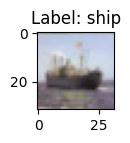

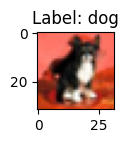

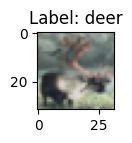

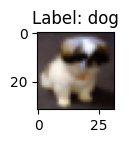

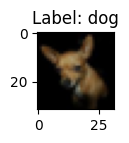

In [7]:
# 3.2 Visualize some samples from the test split.
# Set CIFAR-10 classes.
cifar10_class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def imshow(img, title=None):
    plt.figure(figsize=(1, 1))  # Set the figure size to 2 inches by 2 inches
    plt.imshow(np.transpose(img, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def show_samples(dataset, num_samples=5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i in indices:
        sample = dataset[int(i)]
        image = sample['img']
        label = sample['label']
        text_label = cifar10_class_names[label]  # Convert numeric label to text label
        imshow(image, f"Label: {text_label}")

# Show a few random samples from test set.
show_samples(test_set, num_samples=5)

This tutorial will highlight impact of leveraging pretrained image encoders, i.e. features learned by the model on another (bigger) dataset.

In particular, in the second part we will fine-tune ResNet-18 model pretrained on the ImageNet dataset. ImageNet is a large-scale dataset containing more than 14 million images across 20,000 categories. The pretrained models provided by torchvision have been trained on a subset of ImageNet with 1,000 categories and 1.2 million images.

When using a pretrained model, it's important to apply the same preprocessing and normalization that was used during the original pretraining. For the ImageNet dataset, the following normalization is typically used:

In [1]:
# 3.3 Change samples in the training and validation sets to tensors, and
# additionally apply a typical ImageNet normalization.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Subset of train split.
train_set = dataset['train[0:5000]'].map(lambda x: {'img': transform(x['img'])})
train_set = train_set.with_format("pytorch")#, device=device)

# Subset of test split.
valid_set = dataset['test[0:10000]'].map(lambda x: {'img': transform(x['img'])})
valid_set = valid_set.with_format("pytorch")#, device=device)     

NameError: ignored

In [9]:
# Step 4: Create DataLoaders
# 4.1 Set the batch size.
batch_size = 64

# 4.2 Create DataLoaders for the training and validation sets.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [11]:
# Step 5: Define the models.

# 5.1 Initialize a new model based on ResNet-18 architecture.
model = models.resnet18(num_classes=10)

# 5.2 Initialize a ResNet-18 model pretrained on Imagenet.
pretrained_model = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1)

# 5.2.1 Replace the last layer to match the number of classes in your dataset (10 for CIFAR-10).
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 10)

# 5.3 Move the models to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
pretrained_model = pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 336MB/s]


In [14]:
# Step 6: Train the model.
# 6.1 Set up the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def calculate_accuracy(outputs, labels):
    """ Calculate the accuracy of the model predictions for a batch of inputs. """
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


# 6.2  Define the training loop.
def train_model(model, num_epochs, criterion, optimizer, log_dir):
    writer = SummaryWriter(log_dir=log_dir)

    # Reset lists.
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Train the model for one epoch
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate the number of FLOPs for this iteration
            train_losses.append(loss.item())
            train_acc = calculate_accuracy(outputs, labels)
            train_accuracies.append(train_acc)

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_acc = 0.0
            for data in valid_loader:
                inputs, labels = data['img'].to(device), data['label'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                valid_acc += calculate_accuracy(outputs, labels) * inputs.size(0)

            valid_loss /= len(valid_loader.dataset)
            valid_losses.append(valid_loss)
            valid_acc /= len(valid_loader.dataset)
            valid_accuracies.append(valid_acc)

        # Print the training loss and accuracy for this epoch
        print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Valid Loss = {valid_loss:.4f}, Valid Acc = {valid_acc:.4f}")

    writer.close()



In [15]:
# 6.2 Train the model from the scratch and log the data.
num_epochs = 1
train_model(model, num_epochs, criterion, optimizer, os.path.join(log_dir, 'model_scratch'))


TypeError: ignored

In [ ]:
# 6.3 Fine-tune the pretrained model and log the data.
train_model(pretrained_model, num_epochs, criterion, optimizer, os.path.join(log_dir, 'pretrained_model'))
